# Multivariate two factorial ANOVA 

In order to detect masks with early emerging signals we can run varaiance analysis ANOVA. This will tell us if there are differences between SSPs, but will not serve to differantiate new observations. The goal is to detect which masks allows for an early seperation between SSPs, this allows for easier development of ML algs.

Here we run two factorial design hereunder
- Mask as factor, with global levels of nomask, seamask and landmask
- SSP as factor, with levels SSP126, SSP245, SSP370 and SSP585¨
Since all levels of each factor occours in combination we have 12 groups and a crossed model design (in difference to a nested model design). 

We run the factors as descriptive variables for observations of tas, pr, txx and rx5day. Since the interaction between these responsvariables is what will allow us to detect SSP seperation early we use multivariate analysis of variance or MANOVA. 

Since we use a yearly cross-sectional approach for classification we run two-factorial MANOVA on each cross section.  

## Preprocessing of data and initial investigation
In order to enable the analysis we need to transform our data from seperate multivariate time series files on the .nc format, to a table for each seperate cross section (year). The format will be:

| # | Mask | SSP | tas_value | pr_value | txx_value | rx5day_value |
| --|---|---|---|---|---|---|
....

This allows to run the analysis directly if each realization gets one row each. While performing this preprocessing some initial investigations will be performed.


### Investigations of time series ensambles.
It is always important to know the big picture of what you are looking at. Therefor we start by presenting the ensambles of each variable under different masks. In order to calculate the ensambles we use the xclim library. 

**Resources:**
- https://xclim.readthedocs.io/en/stable/index.html
    - https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html

#### Import libraries

In [109]:
from pathlib import Path
from src.preproces import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from xclim import ensembles
import pandas as pd
import xarray as xr


file_handler = Handle_Files()

Support functions for plotting

In [102]:
def legend_without_duplicate_labels(fig):
    handles, labels = fig.axes[0].get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    fig.legend(*zip(*unique), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

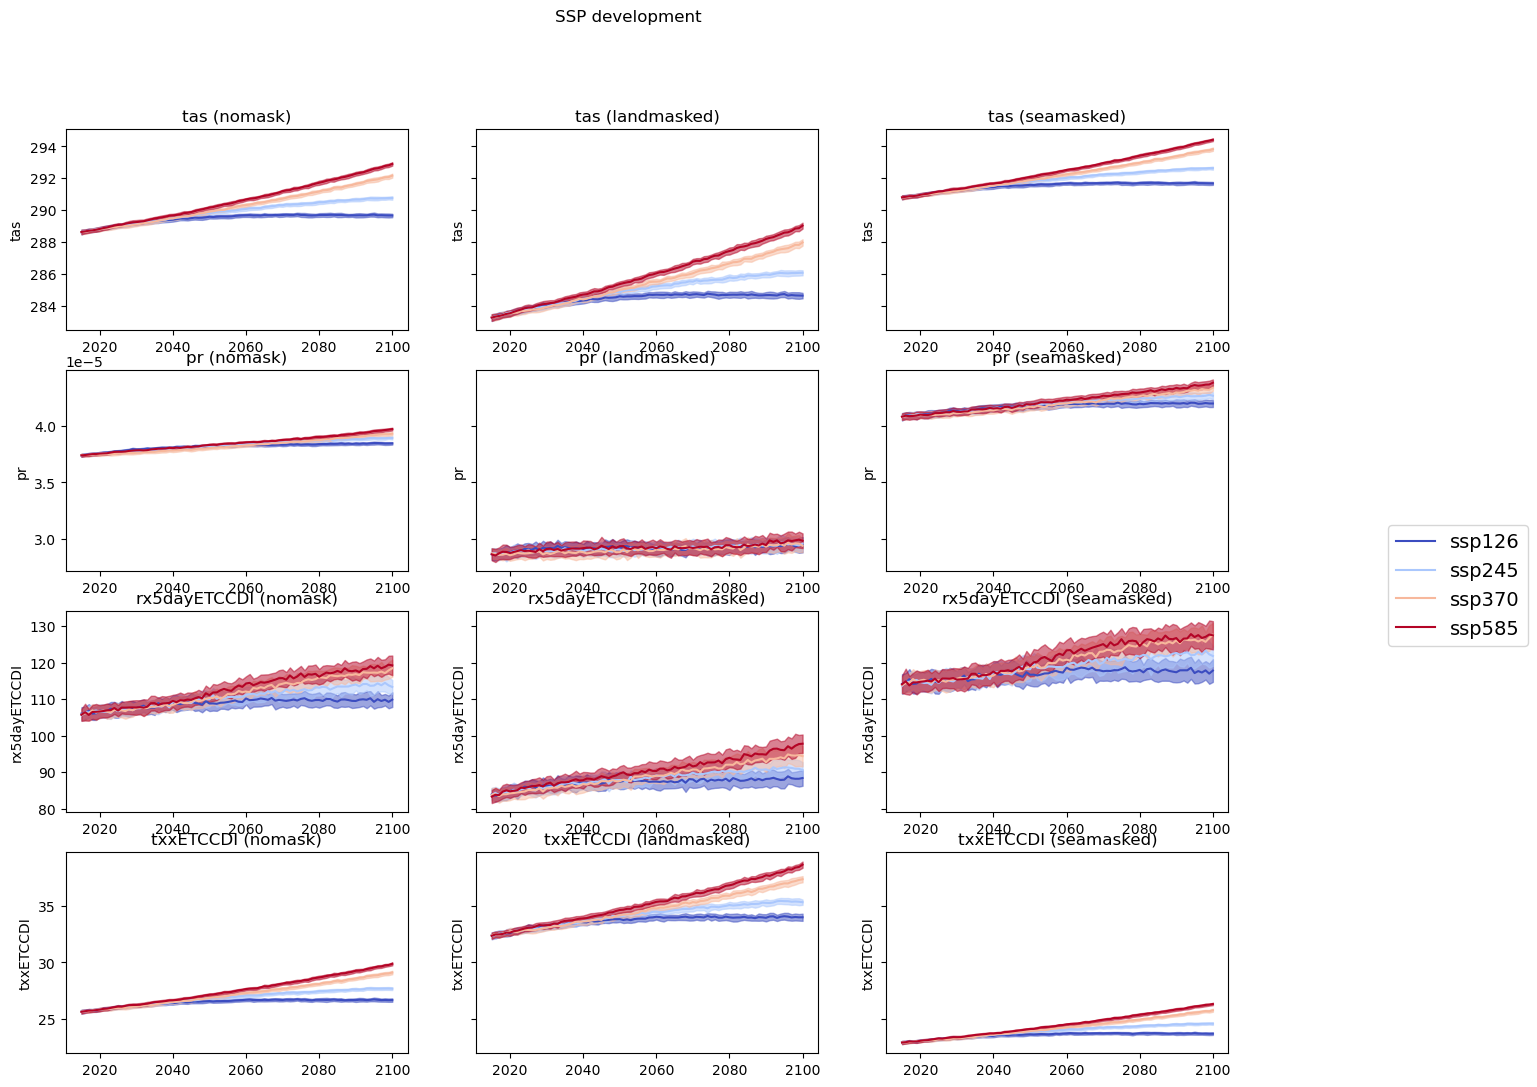

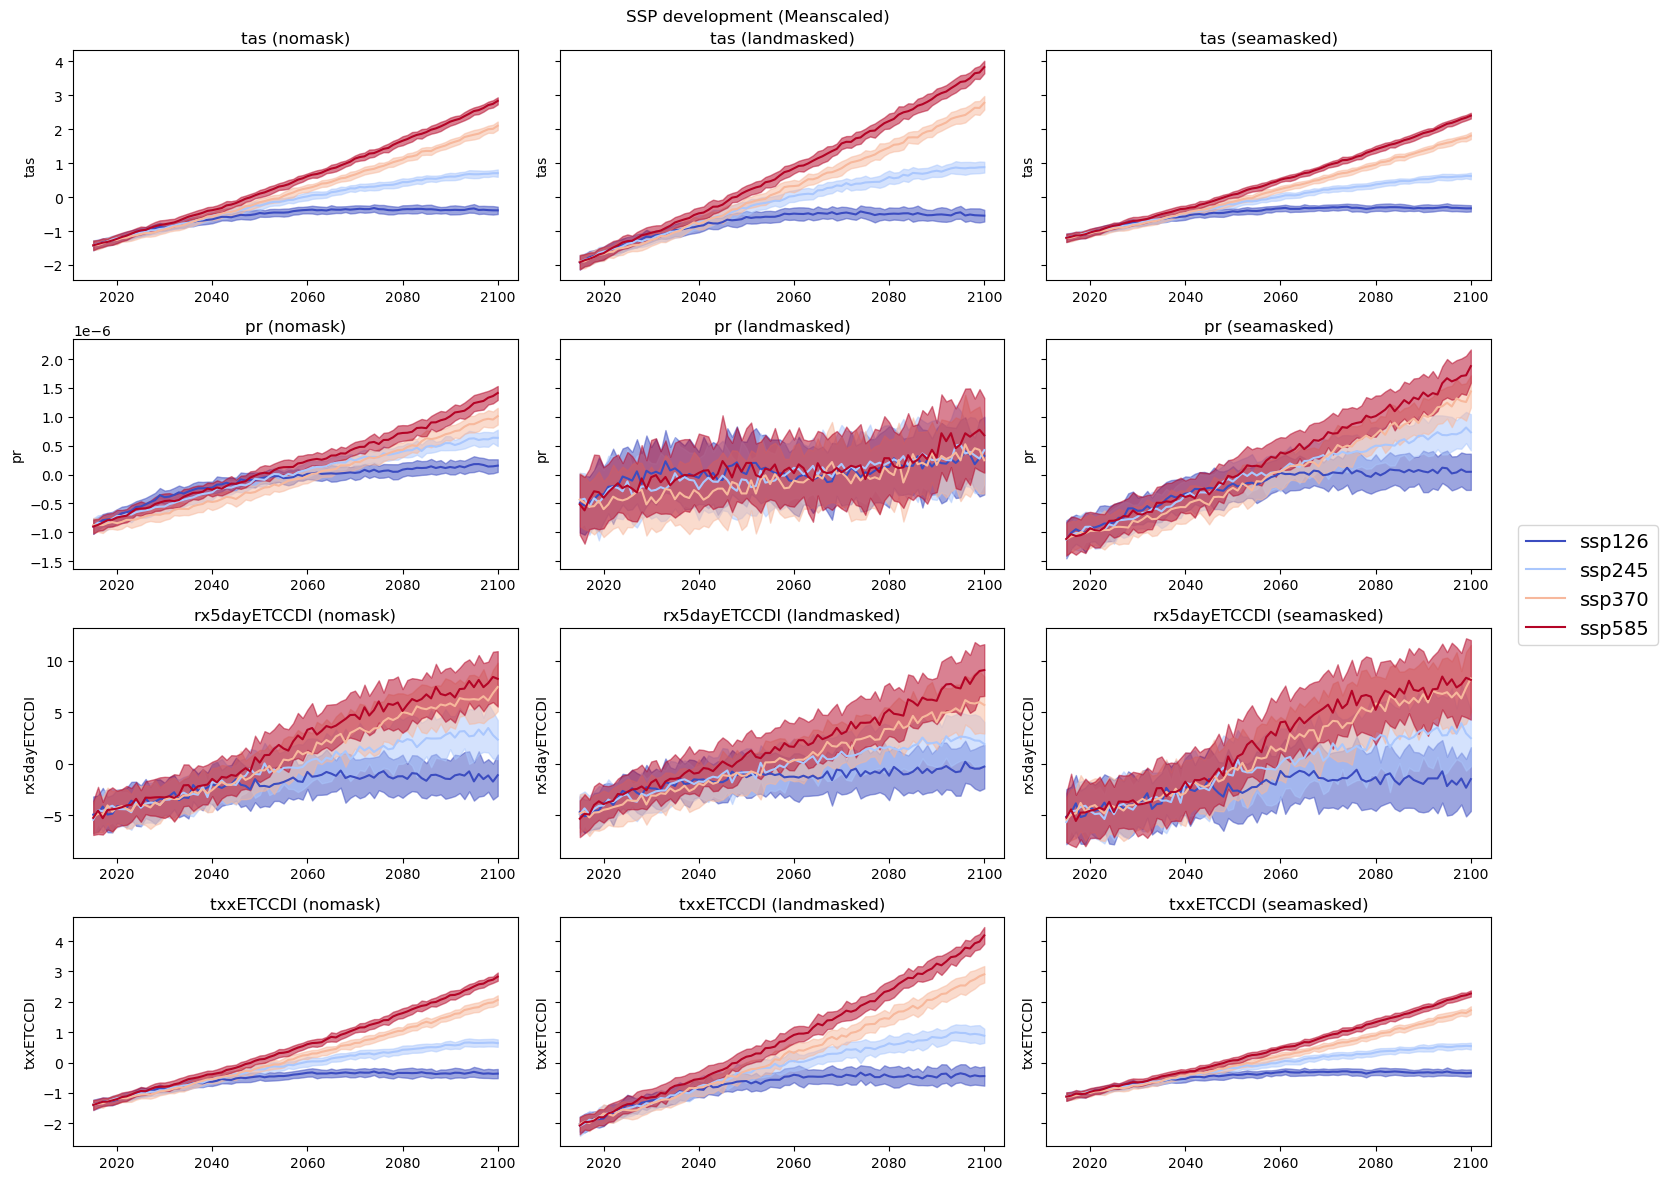

In [103]:

fig, axs = plt.subplots(4, 3, figsize=(15, 12), sharey='row')#, sharex='col')
fig2, axs2 = plt.subplots(4, 3, figsize=(15, 12), sharey='row')#, sharex='col')

fig.suptitle('SSP development')
fig2.suptitle('SSP development (Meanscaled)')

main_data_dir = 'D:/Programmering/msc/Masterthesis_S23_DataFiles/AnnualGlobalClimatologies'
masks = ['nomask', 'landmasked', 'seamasked']
SSPs = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
variables = ['tas', 'pr', 'rx5dayETCCDI', 'txxETCCDI']

colors = plt.cm.coolwarm(np.linspace(0, 1, len(SSPs)))
color_map = dict(zip(SSPs, colors))

for i, mask in enumerate(masks):
    
    for j, variable in enumerate(variables):
        axs[j, i].set_ylabel(variable)
        axs[j, i].set_title(f'{variable} ({mask})')
        axs2[j, i].set_ylabel(variable)
        axs2[j, i].set_title(f'{variable} ({mask})')

        means = {}
        stds = {}
        for scenario in SSPs:
            data_dir = '/'.join([main_data_dir, mask, variable, scenario])
            
            ens = ensembles.create_ensemble(Path(data_dir).glob("*.nc"))
            ens_stats = ensembles.ensemble_mean_std_max_min(ens)
            
            ens_mean = ens_stats[f'{variable}_mean']
            ens_std = ens_stats[f'{variable}_stdev']
            axs[j, i].plot(ens_stats.year, ens_mean, 
                           label=scenario,
                           color=color_map[scenario])
            axs[j, i].fill_between(ens_stats.year, ens_mean - ens_std, ens_mean + ens_std, 
                                   color=color_map[scenario],
                                   alpha=0.5)

            means[scenario] = ens_mean
            stds[scenario] = ens_std
        
        subfig_mean = [scenario_mean.mean().values.item() for scenario_mean in means.values()]
        subfig_mean = np.mean(subfig_mean)

        for scenario in means.keys(): 
            # meanscaled version
            # Kan ikke skalere med gruppegjennomsnittet må benytte gjennomsnittet av alle sspene
            meanscaled_ens_mean = means[scenario] - subfig_mean
            axs2[j, i].fill_between(ens_stats.year, meanscaled_ens_mean - stds[scenario], meanscaled_ens_mean + stds[scenario], 
                                   color=color_map[scenario],
                                   alpha=0.5)
            axs2[j, i].plot(ens_stats.year, meanscaled_ens_mean, 
                            label=scenario,
                            color=color_map[scenario])
            

legend_without_duplicate_labels(fig)
legend_without_duplicate_labels(fig2)
plt.tight_layout()
plt.show()

### Datawrangling for table creation

In [99]:
def extract_cross_sections(main_data_dir, masks, SSPs):
    
    data_frames = {}
    for year in range(2015, 2101):
        data_frames[year] = pd.DataFrame(columns=['mask', 'SSP', 'year', 'tas', 'pr', 'rx5dayETCCDI', 'txxETCCDI'], 
                                         index=range(len(masks)*len(SSPs)*40))
    
    indx = 0
    for mask in masks:
        for scenario in SSPs:
            data_dir = '/'.join([main_data_dir, mask, 'multivariate', scenario])
            file_names = file_handler.get_all_netcdf_files_in_dir(data_dir)
            
            for file_name in file_names:

                ds = file_handler.read_netcdf_to_xr(directory=data_dir, 
                                                    file_name=file_name)
                
                for year in range(2015, 2101):
                    ds_year = ds.sel(year=year)
                    data_frames[year].loc[indx] = [mask, 
                                                   scenario, 
                                                   ds_year.year.values.item(),
                                                   ds_year.tas.values.item(), 
                                                   ds_year.pr.values.item(), 
                                                   ds_year.rx5dayETCCDI.values.item(), 
                                                   ds_year.txxETCCDI.values.item()]
                
                indx += 1   
    return data_frames            

In [100]:
masks = ['nomask', 'landmasked', 'seamasked']

data_frames = extract_cross_sections(main_data_dir, masks, SSPs)

In [98]:
import os

main_save_dir = 'D:/Programmering/msc/Masterthesis_S23_DataFiles/AnnualGlobalClimatologies/tables'

for year, df in data_frames.items():
    file_name = f"tab_glob_yr_climatology_{year}.csv"
    file_path = os.path.join(main_save_dir, file_name)
    df.to_csv(file_path, index=False)


### Boxplots 
one for every fift years?


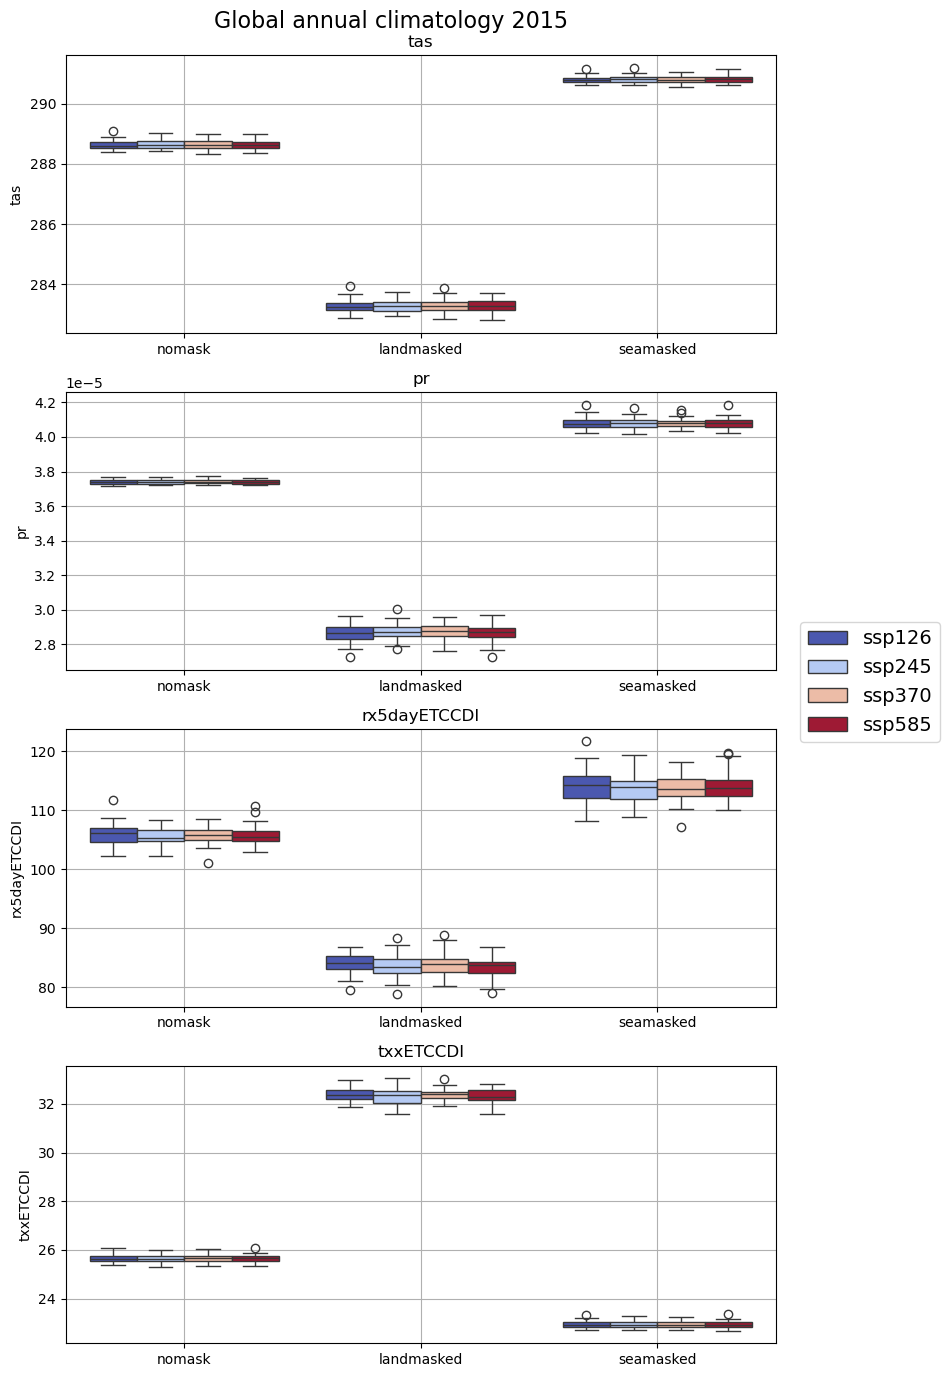

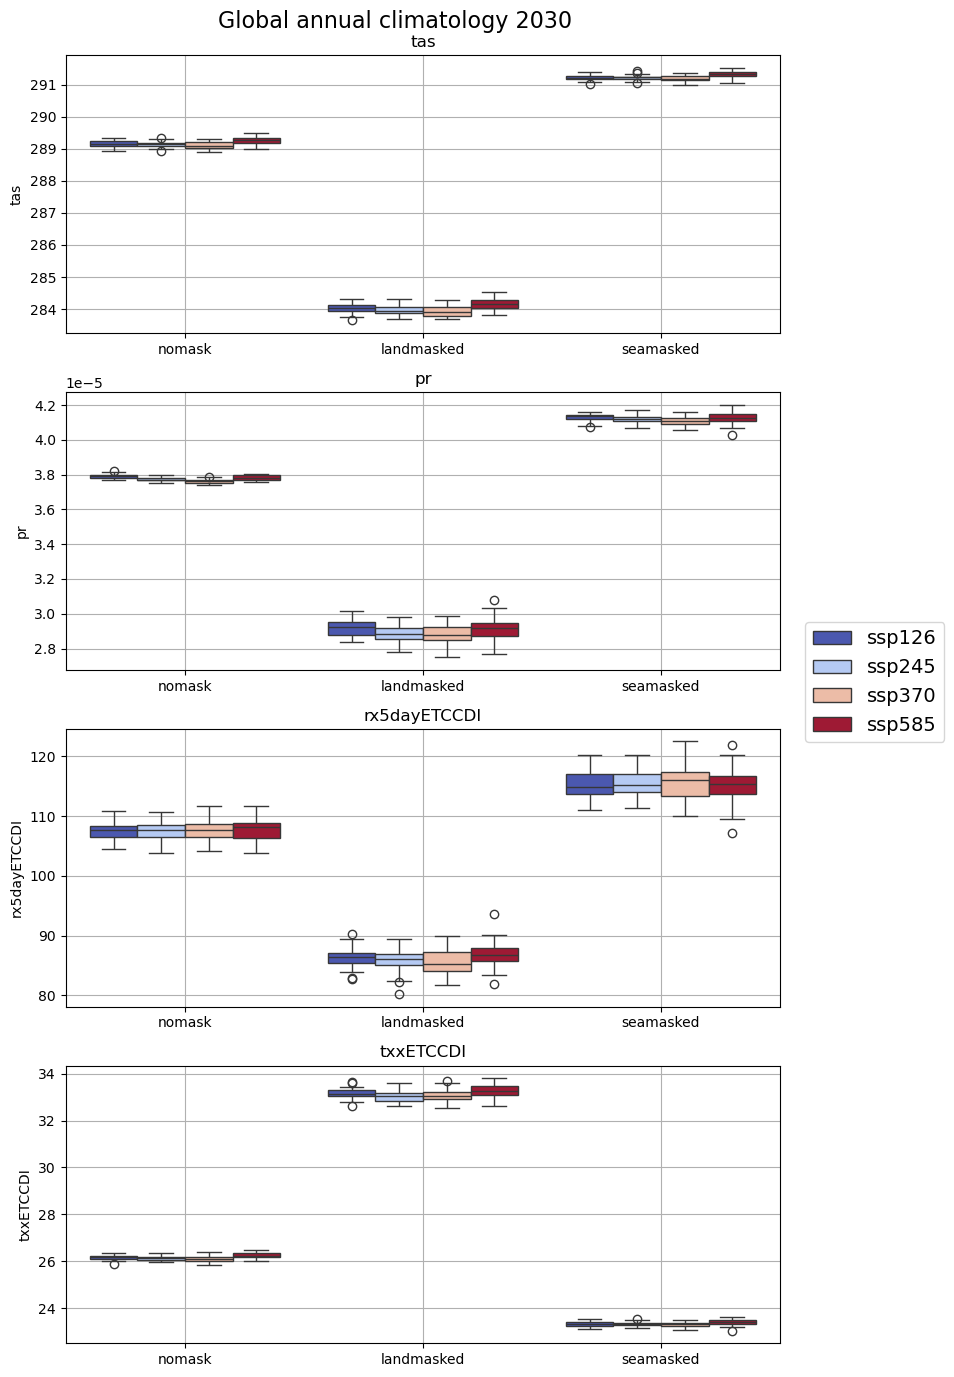

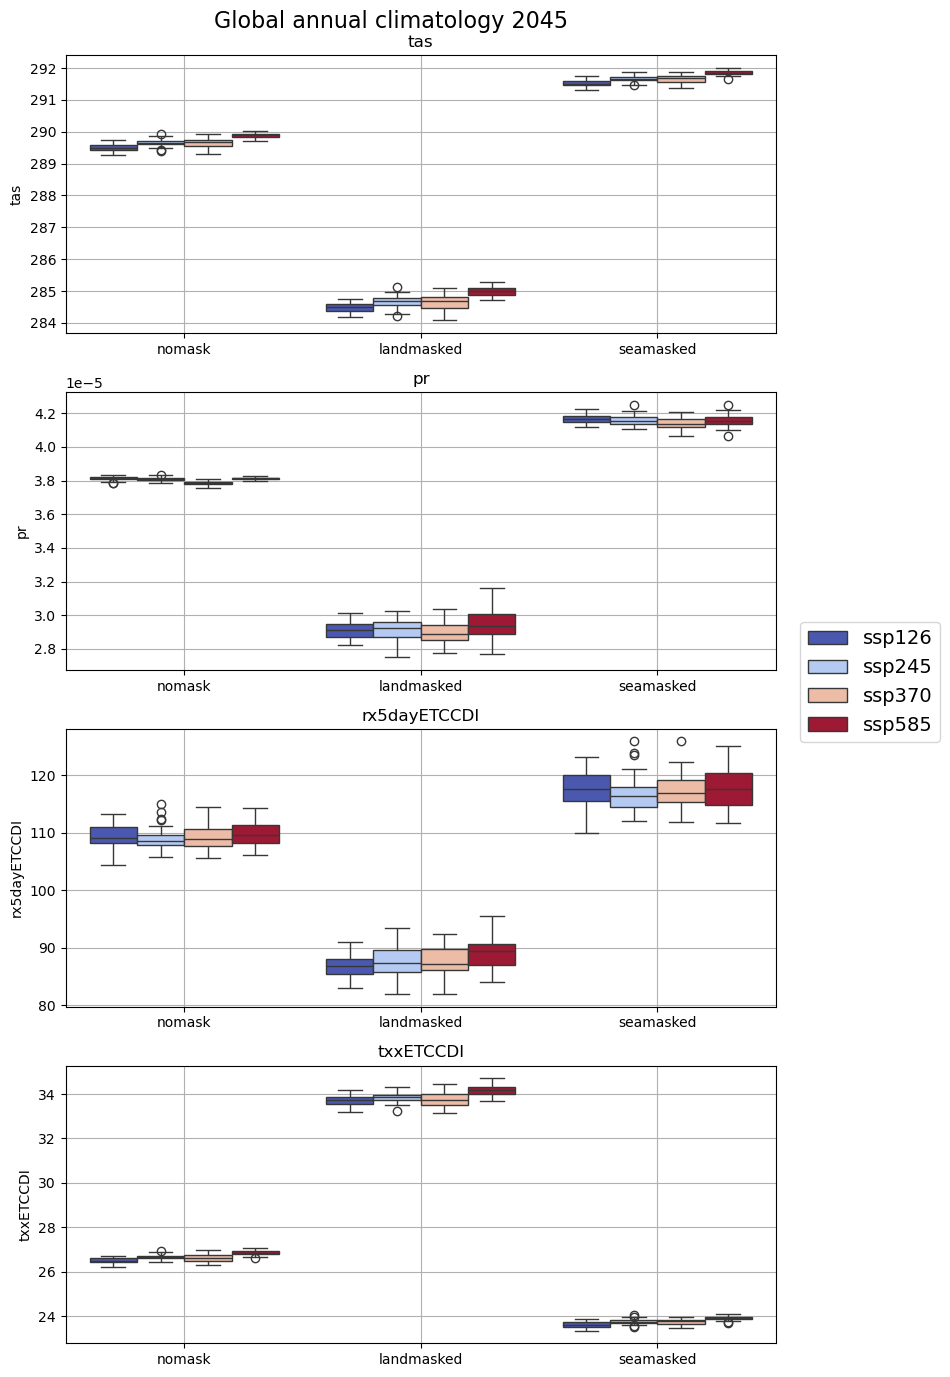

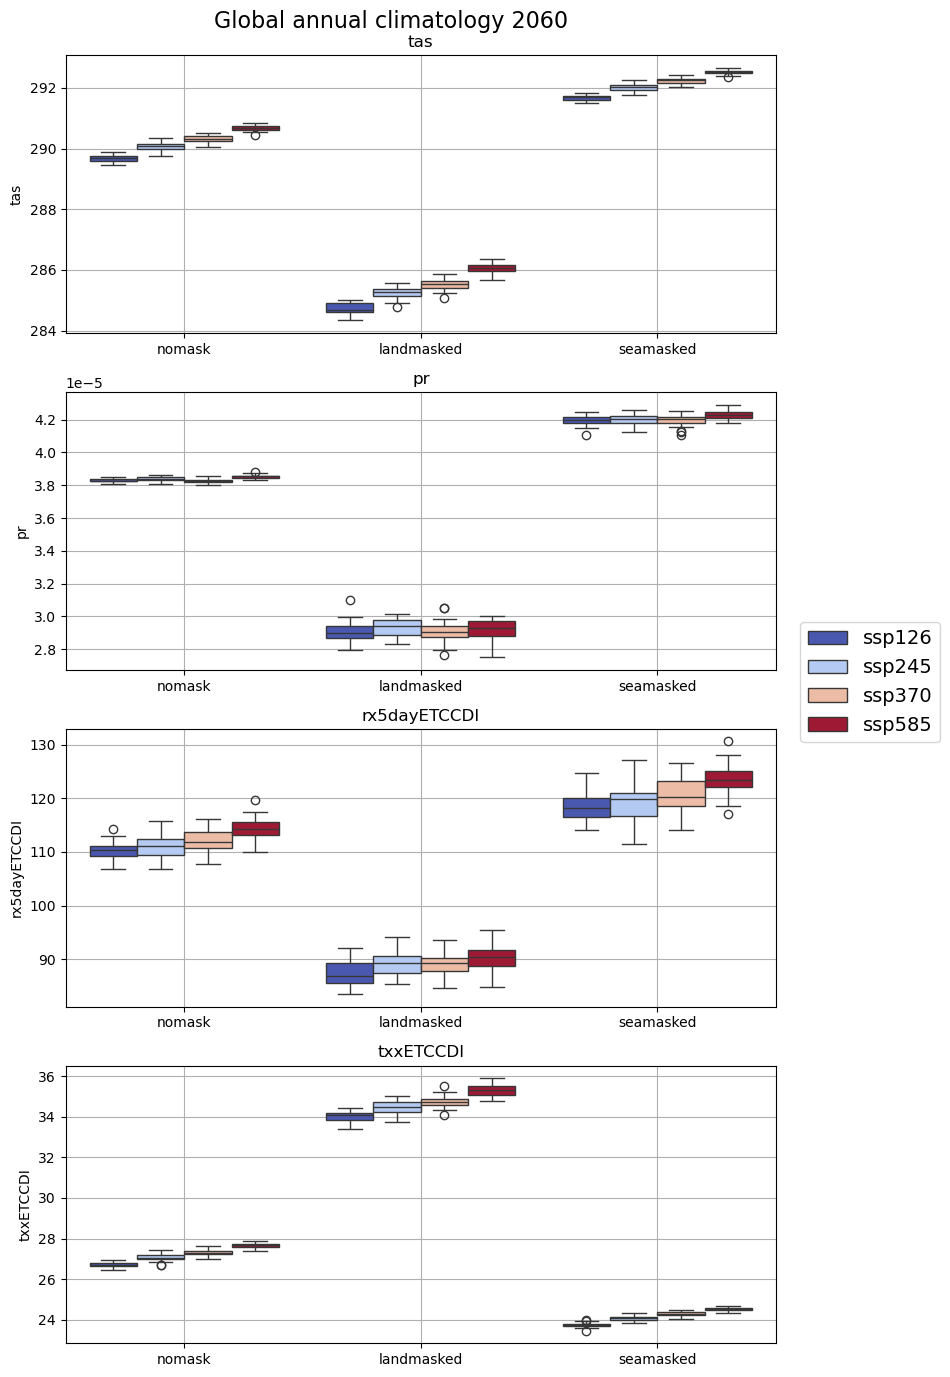

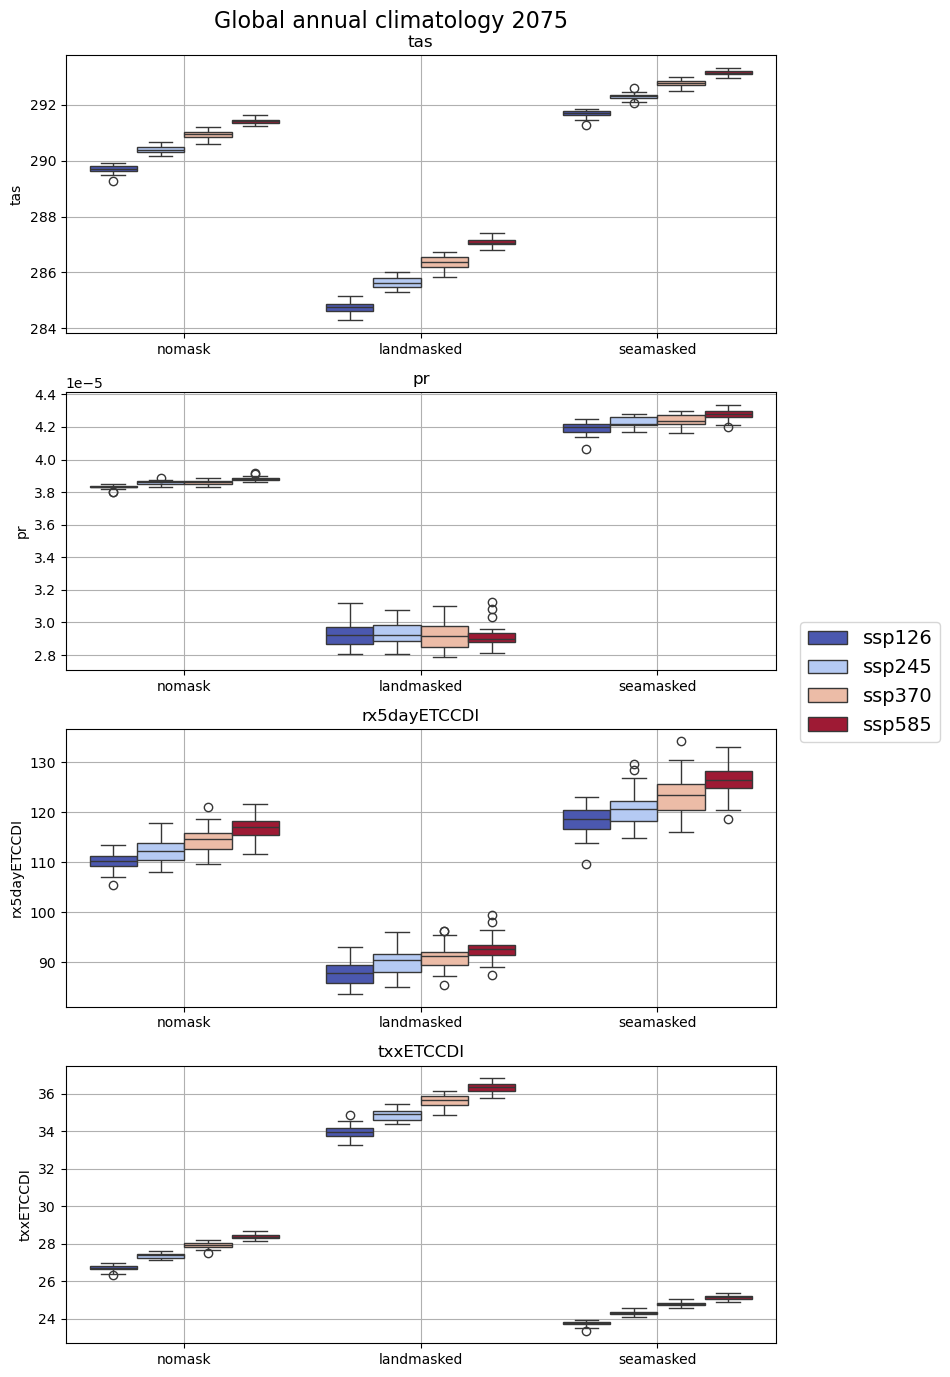

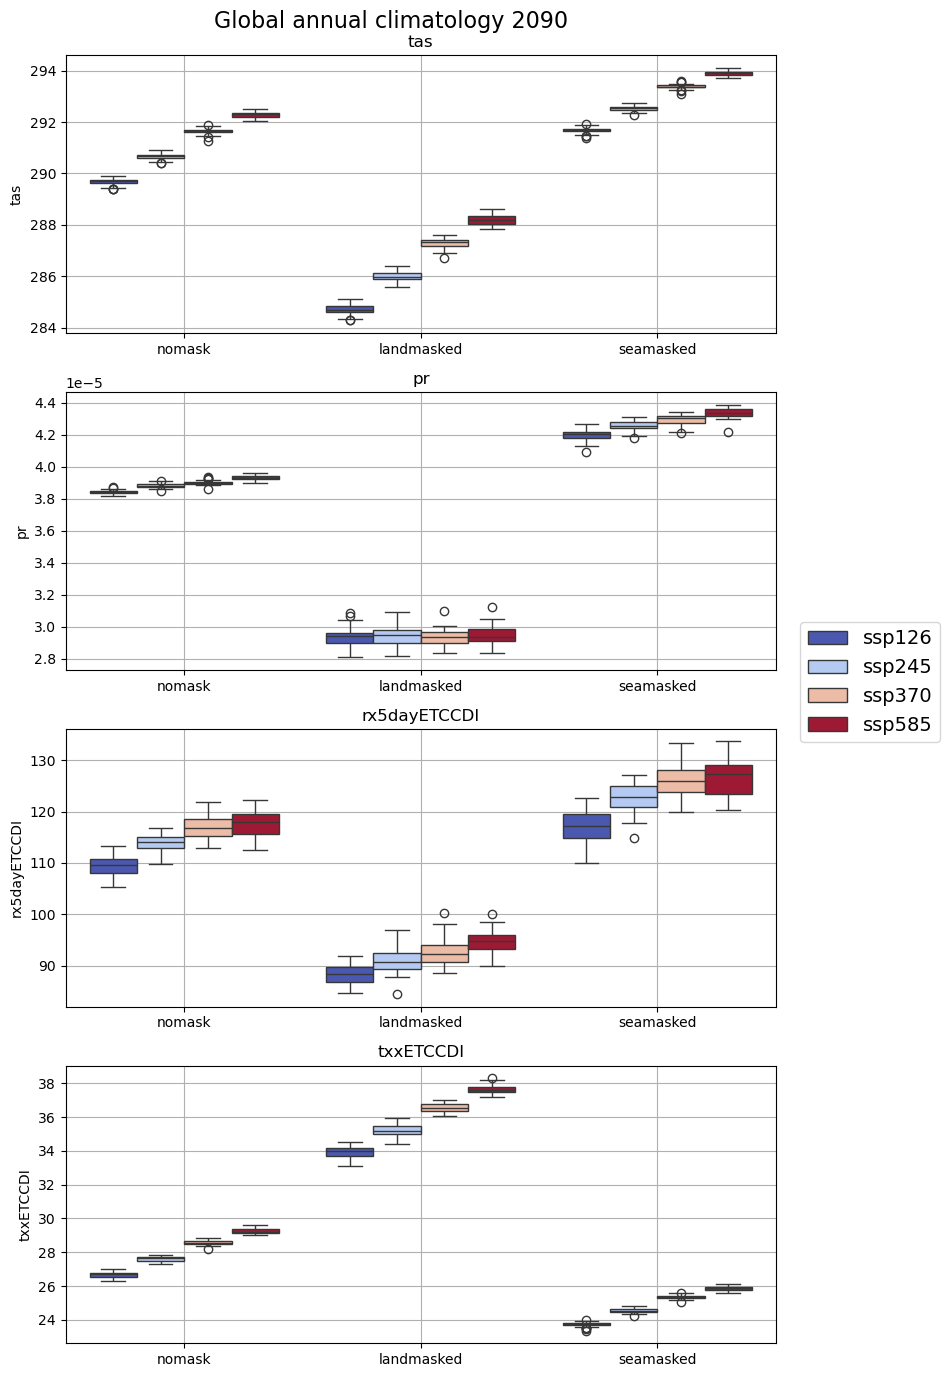

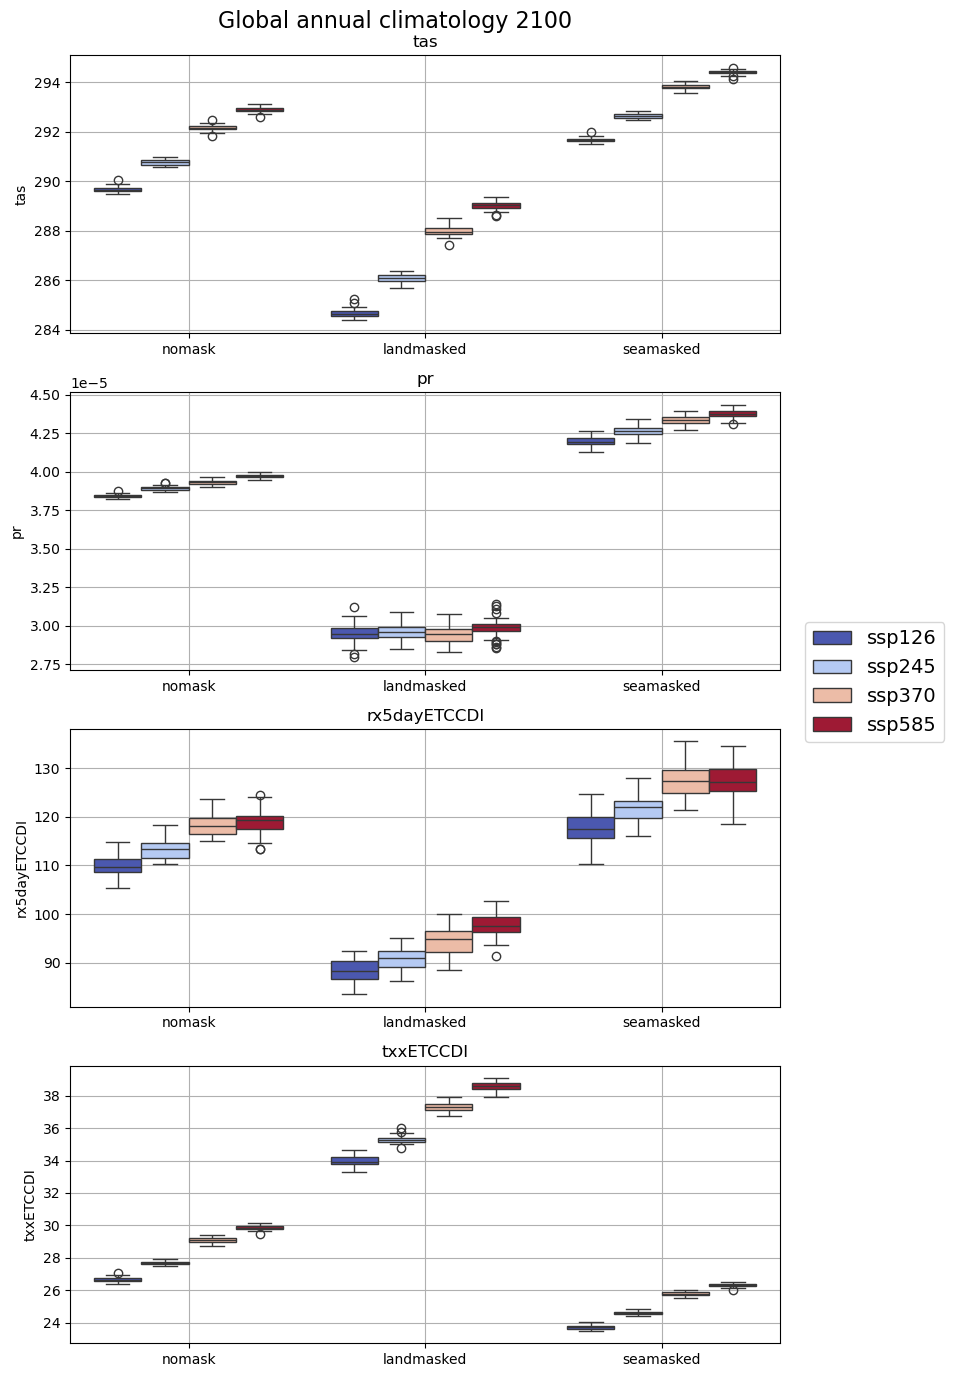

In [127]:
years = [2015, 2030, 2045, 2060, 2075, 2090, 2100]

for year in years:
    # Create a figure with four subplots
    fig, axs = plt.subplots(4, 1, figsize=(8, 14))
    fig.suptitle(f'Global annual climatology {year}', fontsize=16)

    df = data_frames[year]
    # Iterate over each variable
    for i, variable in enumerate(variables):
        # Get the data frame for the variable
        df_variable = df[['SSP', 'mask', variable]]
        
        # Create a boxplot for each SSP and each mask
        ax = axs[i]
        sns.boxplot(x='mask', 
                    y=variable, 
                    hue='SSP', 
                    data=df_variable, 
                    ax=ax, 
                    palette=color_map)
        ax.set_title(variable)
        ax.set_xlabel('')
        ax.set_ylabel(variable)
        ax.grid(True)
        ax.get_legend().remove()

    legend_without_duplicate_labels(fig)
    plt.tight_layout()
    plt.show()


It is obvious that the mask creates differences in mean, and so we do not need to run two-factor MANOVA, we drop the masking as a factor and investigate the intramask variance.

## MANOVA

### MANOVA adequacy checking
- The assumption of multivariate normality is checked statistically by:
1. Using shapiro-wilks test on univariate distributions if this test does not pass (significant p value), it may be possible that multivariate normality is violated.
- The Shapiro-Wilk test is a statistical test used to assess whether a given sample of data comes from a normally distributed population. The test produces a test statistic and a p-value, which are used to make this assessment
    - Null Hypothesis: The null hypothesis of the Shapiro-Wilk test is that the sample is drawn from a normally distributed population.
    - Interpretation:
        - If the p-value is greater than the chosen alpha level (e.g., 0.05), there is not enough evidence to reject the null hypothesis, and the data can be considered to be normally distributed.
        - If the p-value is less than the chosen alpha level, the null hypothesis is rejected, indicating that the data significantly deviates from a normal distribution.

2. using Henze-Zirkler's multivariate normality test.
3. visual check using QQ plots

*Resources:*
- https://www.reneshbedre.com/blog/manova
- https://link.springer.com/article/10.1007/s11749-020-00740-0
    - https://pingouin-stats.org/build/html/generated/pingouin.multivariate_normality.html

In [156]:
from scipy.stats import shapiro
import pingouin as pg

In [204]:
shapiro_violations = 0
shapiro_counter = 0
HZ_violations = 0
HZ_counter = 0
# Perform Mardia's Skewness and Kurtosis test
for year in range(2015, 2101):

    ssp126_df = data_frames[year][data_frames[year]['SSP'] == 'ssp126']
    ssp245_df = data_frames[year][data_frames[year]['SSP'] == 'ssp245']
    ssp370_df = data_frames[year][data_frames[year]['SSP'] == 'ssp370']
    ssp585_df = data_frames[year][data_frames[year]['SSP'] == 'ssp585']

    year_df_dict = {
        'ssp126': {'nomask': ssp126_df[ssp126_df['mask'] == 'nomask'][variables],
                   'landmasked': ssp126_df[ssp126_df['mask'] == 'landmasked'][variables],
                   'seamasked': ssp126_df[ssp126_df['mask'] == 'seamasked'][variables]},
        'ssp245': {'nomask': ssp245_df[ssp245_df['mask'] == 'nomask'][variables],
                   'landmasked': ssp245_df[ssp245_df['mask'] == 'landmasked'][variables],
                   'seamasked': ssp245_df[ssp245_df['mask'] == 'seamasked'][variables]},
        'ssp370': {'nomask': ssp370_df[ssp370_df['mask'] == 'nomask'][variables],
                   'landmasked': ssp370_df[ssp370_df['mask'] == 'landmasked'][variables],
                   'seamasked': ssp370_df[ssp370_df['mask'] == 'seamasked'][variables]},
        'ssp585': {'nomask': ssp585_df[ssp585_df['mask'] == 'nomask'][variables],
                   'landmasked': ssp585_df[ssp585_df['mask'] == 'landmasked'][variables],
                   'seamasked': ssp585_df[ssp585_df['mask'] == 'seamasked'][variables]}
                    }
    

    for scenario, df_dict in year_df_dict.items():
        for mask, data in df_dict.items():
            HZ_counter += 1
            for variable in variables:
                shapiro_counter += 1
                variable_data = data[variable].to_numpy(np.float32)
                        
                stats, p_value = shapiro(variable_data)
                if p_value < 0.05:
                    shapiro_violations += 1
                    print(f"Shapiro-Wilk test failed {shapiro_violations} of {shapiro_counter}:\n"  
                          f"Year: {year}, Mask: {mask}, SSP: {scenario}, Variable: {variable}, \n"
                          f"p-value: {p_value}")
                    
                    
            mv_data = data.to_numpy(np.float32)
            mv_stats = pg.multivariate_normality(mv_data, alpha=0.05)
            if mv_stats[2] is False:
                HZ_violations += 1
                print(f"Multivariate normality test failed {HZ_violations} of {HZ_counter} \n"
                      f"Year: {year}, Mask: {mask}, SSP: {scenario}, \n"
                      f"p-value: {mv_stats[1]}")

Multivariate normality test failed 1 of 1 
Year: 2015, Mask: nomask, SSP: ssp126, 
p-value: 1.6030891451248287e-151
Multivariate normality test failed 2 of 2 
Year: 2015, Mask: landmasked, SSP: ssp126, 
p-value: 0.014892491069343058
Multivariate normality test failed 3 of 3 
Year: 2015, Mask: seamasked, SSP: ssp126, 
p-value: 0.0
Multivariate normality test failed 4 of 4 
Year: 2015, Mask: nomask, SSP: ssp245, 
p-value: 7.704761379538998e-119
Multivariate normality test failed 5 of 5 
Year: 2015, Mask: landmasked, SSP: ssp245, 
p-value: 0.00027756978702023725
Multivariate normality test failed 6 of 6 
Year: 2015, Mask: seamasked, SSP: ssp245, 
p-value: 0.0
Multivariate normality test failed 7 of 7 
Year: 2015, Mask: nomask, SSP: ssp370, 
p-value: 3.0506005771704716e-267
Multivariate normality test failed 8 of 9 
Year: 2015, Mask: seamasked, SSP: ssp370, 
p-value: 0.0
Multivariate normality test failed 9 of 10 
Year: 2015, Mask: nomask, SSP: ssp585, 
p-value: 1.5350905825946962e-278
Mul

### MANOVA testing

In [455]:
from statsmodels.multivariate.manova import MANOVA
import itertools
from tqdm import tqdm

In [381]:
def preprocess_for_anova(df, factors, variables):


    df = df.loc[:, factors + variables]  # Keep only columns in factors or variables

    for variable in variables:
        df[variable] = df[variable].astype(np.float32)
        
    for factor in factors:
        df[factor] = df[factor].astype('category')
    
    return df

In [447]:

def find_combinations(variables):
    combinations = []
    for r in range(2, len(variables) + 1):
        combinations.extend(list(itertools.combinations(variables, r)))
    
    combinations = [list(comb) for comb in combinations]
    return combinations

combinations = find_combinations(variables)
for combination in combinations:
    print(combination)

['tas', 'pr']
['tas', 'rx5dayETCCDI']
['tas', 'txxETCCDI']
['pr', 'rx5dayETCCDI']
['pr', 'txxETCCDI']
['rx5dayETCCDI', 'txxETCCDI']
['tas', 'pr', 'rx5dayETCCDI']
['tas', 'pr', 'txxETCCDI']
['tas', 'rx5dayETCCDI', 'txxETCCDI']
['pr', 'rx5dayETCCDI', 'txxETCCDI']
['tas', 'pr', 'rx5dayETCCDI', 'txxETCCDI']


In [463]:
years = list(range(2015, 2030))

p_values_all_combinations = {}
for var_comb in combinations:
    var_comb_str = '+'.join(var_comb) + '~SSP'

    p_values_df = pd.DataFrame(columns=['Year', 'Mask', 'Wilks Lambda', 'Pillai\'s Trace'], 
                               index=range(len(masks)*len(years)))

    indx = 0
    for year in years:
        df_yr = data_frames[year]

        for mask in masks:
            df_mask = df_yr[df_yr['mask'] == mask]
            df_mask = preprocess_for_anova(df_mask, ['SSP'], var_comb)
            manova_result = MANOVA.from_formula(var_comb_str, data=df_mask)
            wilkslambda = manova_result.mv_test().results['SSP']['stat']['Pr > F'].iloc[0]
            pillaistrace = manova_result.mv_test().results['SSP']['stat']['Pr > F'].iloc[1]
            
            p_values_df.loc[indx] = [year, mask, wilkslambda, pillaistrace]
            indx += 1
    
    p_values_all_combinations[var_comb_str.replace('~SSP', '').replace('+', ', ')] = p_values_df


In [464]:
p_values_all_combinations

{'tas, pr':     Year        Mask Wilks Lambda Pillai's Trace
 0   2015      nomask     0.935005       0.934436
 1   2015  landmasked     0.965374       0.964964
 2   2015   seamasked      0.99664       0.996587
 3   2016      nomask     0.422539       0.419661
 4   2016  landmasked     0.550112       0.547152
 5   2016   seamasked     0.837503         0.8357
 6   2017      nomask     0.088917       0.092556
 7   2017  landmasked     0.674585       0.671686
 8   2017   seamasked     0.103757       0.104608
 9   2018      nomask     0.065641       0.068338
 10  2018  landmasked     0.445494       0.443563
 11  2018   seamasked     0.959376       0.958827
 12  2019      nomask     0.089007       0.088619
 13  2019  landmasked     0.696939       0.693973
 14  2019   seamasked     0.626353       0.623668
 15  2020      nomask     0.000009       0.000017
 16  2020  landmasked     0.057709       0.058951
 17  2020   seamasked     0.790021       0.789184
 18  2021      nomask     0.000001     

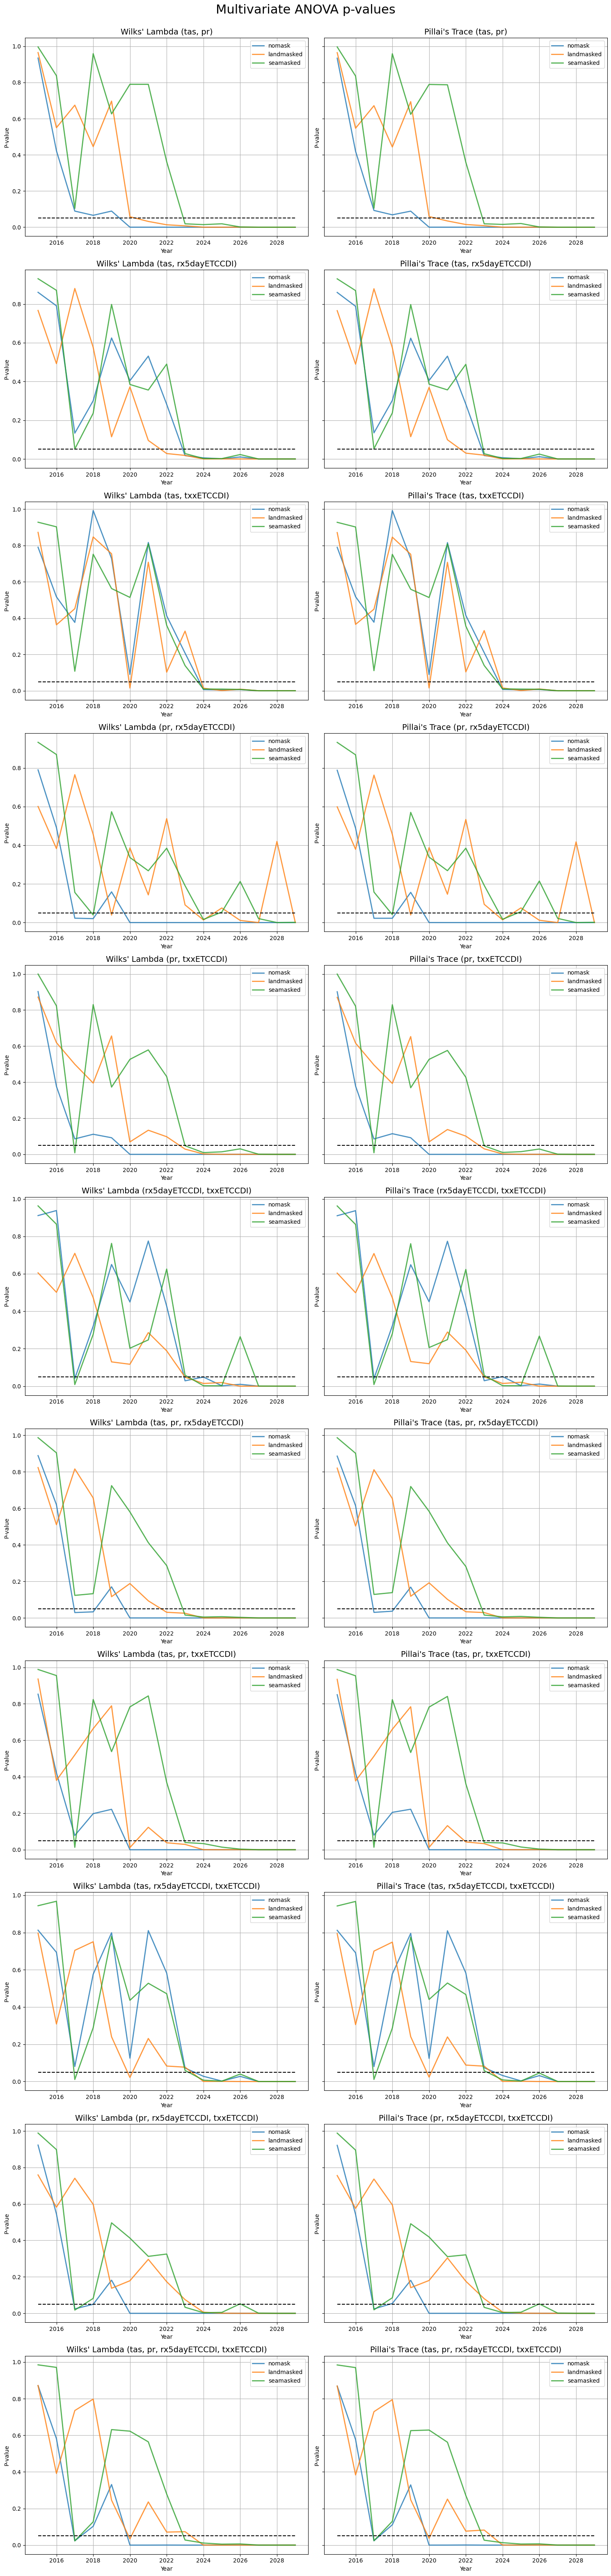

In [479]:

years = list(range(2015, 2030))

fig, axs = plt.subplots(11, 2, figsize=(15, 11*6), sharey='row')

fig.suptitle('Multivariate ANOVA p-values', fontsize=22)

#fig.suptitle('Multivariate ANOVA p-values', fontsize=18)

for row, (var_comb, p_values_df) in enumerate(p_values_all_combinations.items()):
    wilk_ax = axs[row, 0]
    pil_ax = axs[row, 1]
    wilk_ax.set_title(f'Wilks\' Lambda ({var_comb})', fontsize=14)
    pil_ax.set_title(f'Pillai\'s Trace ({var_comb})', fontsize=14)

    for mask in masks:
        df = p_values_df[p_values_df['Mask'] == mask]
        wilk_ax.plot(years, df['Wilks Lambda'], 
                         label=mask, linewidth=2, alpha=0.8)
        pil_ax.plot(years, df['Pillai\'s Trace'], 
                         label=mask, linewidth=2, alpha=0.8)
    
    for ax in [wilk_ax, pil_ax]:
        ax.hlines(0.05, years[0], years[-1], color='black', linestyle='--')
        ax.set_xlabel('Year')
        ax.set_ylabel('P-value')
        ax.legend(loc='upper right')
        ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust the rect parameter to position the suptitle
plt.show()

### Post-hoc Linear disciminant analysis (LDA)

In [480]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

In [483]:
years = list(range(2015, 2020))
for var_comb in combinations:

    for year in years:
        df_yr = data_frames[year]

        for mask in masks:
            
            lda = lda()
            df_mask = df_yr[df_yr['mask'] == mask]
            df_mask = preprocess_for_anova(df_mask, ['SSP'], var_comb)
            X = df_mask[var_comb]
            y = df_mask['SSP']
            lda.fit(X, y)
            X_lda = lda.transform(X)

            print(post_hoc.means_)


d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` 

[[2.88635259e+02 3.73948683e-05]
 [2.88641914e+02 3.74023714e-05]
 [2.88640394e+02 3.74154683e-05]
 [2.88638235e+02 3.73919160e-05]]
[[2.83283315e+02 2.86907822e-05]
 [2.83285051e+02 2.87426377e-05]
 [2.83304197e+02 2.87523297e-05]
 [2.83283001e+02 2.86659012e-05]]
[[2.90804935e+02 4.07915686e-05]
 [2.90813232e+02 4.07888583e-05]
 [2.90803231e+02 4.07947872e-05]
 [2.90809079e+02 4.07992379e-05]]
[[2.88682063e+02 3.74479007e-05]
 [2.88684356e+02 3.74576977e-05]
 [2.88649763e+02 3.74155043e-05]
 [2.88677710e+02 3.74203015e-05]]
[[2.83348228e+02 2.86486058e-05]
 [2.83356935e+02 2.87648030e-05]
 [2.83310248e+02 2.86927394e-05]
 [2.83344283e+02 2.85631403e-05]]
[[2.90844084e+02 4.09023442e-05]
 [2.90842337e+02 4.08633499e-05]
 [2.90813958e+02 4.08402760e-05]
 [2.90840597e+02 4.08826834e-05]]
[[2.88726282e+02 3.75019516e-05]
 [2.88714473e+02 3.74524764e-05]
 [2.88697307e+02 3.74180494e-05]
 [2.88717777e+02 3.74608700e-05]]
[[2.83428683e+02 2.86981231e-05]
 [2.83393317e+02 2.86220307e-05]
 [2

d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` 

[[283.42868271  32.49416118]
 [283.39331665  32.53245835]
 [283.38164902  32.4243742 ]
 [283.38481903  32.46409464]]
[[290.87444382  23.0257854 ]
 [290.87007904  23.00511451]
 [290.85077362  22.98017097]
 [290.87793808  23.03557072]]
[[288.75726929  25.76743474]
 [288.7482399   25.7550159 ]
 [288.75072403  25.76525526]
 [288.73889618  25.75326786]]
[[283.47299881  32.56065421]
 [283.43482895  32.49804249]
 [283.4536644   32.55050163]
 [283.43872604  32.50047455]]
[[290.89793472  23.02129068]
 [290.89896393  23.02619348]
 [290.89683304  23.02116847]
 [290.88274078  23.02214928]]
[[288.77404022  25.77371984]
 [288.81334763  25.82069144]
 [288.78173294  25.79773879]
 [288.78169861  25.79412227]]
[[283.50572739  32.55146241]
 [283.55640106  32.6300642 ]
 [283.5063942   32.58982744]
 [283.51333618  32.61713347]]
[[290.90698471  23.03129568]
 [290.94108734  23.0652019 ]
 [290.91846237  23.05333047]
 [290.91322708  23.03388844]]
[[3.73948683e-05 1.06014787e+02]
 [3.74023714e-05 1.05526559e+02

d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` 

[[83.71037712 32.49416118]
 [83.76008778 32.53245835]
 [83.47464771 32.4243742 ]
 [83.75734806 32.46409464]]
[[115.44073753  23.0257854 ]
 [114.72438278  23.00511451]
 [114.46100636  22.98017097]
 [113.73041725  23.03557072]]
[[106.02733192  25.76743474]
 [106.70364723  25.7550159 ]
 [106.91621628  25.76525526]
 [106.4693325   25.75326786]]
[[84.08905087 32.56065421]
 [84.30370121 32.49804249]
 [83.95007286 32.55050163]
 [84.68192062 32.50047455]]
[[114.10888939  23.02129068]
 [115.09512577  23.02619348]
 [115.47883968  23.02116847]
 [114.54197559  23.02214928]]
[[106.10886765  25.77371984]
 [106.88055134  25.82069144]
 [106.29915047  25.79773879]
 [106.53262997  25.79412227]]
[[84.16078911 32.55146241]
 [84.59673538 32.6300642 ]
 [83.98886623 32.58982744]
 [85.04552212 32.61713347]]
[[114.25202141  23.03129568]
 [115.20687542  23.0652019 ]
 [114.62521152  23.05333047]
 [114.55835686  23.03388844]]
[[2.88635259e+02 3.73948683e-05 1.06014787e+02]
 [2.88641914e+02 3.74023714e-05 1.055265

d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\Python\envs\DataAnalysis\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` 